In [21]:
# pip install fredapi pandas numpy statsmodels
import os
import numpy as np
import pandas as pd
from fredapi import Fred
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM


## Pipeline to prepare data, check cointegration, fit VECM and fit VAR in levels to derive IRFs

In [22]:

# ── 0) FRED API key ─────────────────────────────────────────────────────────────

fred = Fred(api_key="6778de290574049191b08f6b46e3943e")


In [23]:

# ── 1) Pull series ─────────────────────────────────────────────────────────────
# Real GDP, quarterly; CPI, monthly
gdp = fred.get_series("GDPC1")      # Real GDP, quarterly
cpi = fred.get_series("CPIAUCSL")   # CPI, monthly

# Convert to DataFrames with nice column names
gdp = gdp.to_frame(name="gdp")      # index: DatetimeIndex (quarter end)
cpi = cpi.to_frame(name="cpi")      # index: DatetimeIndex (month end)



In [24]:
# ── 2) Make CPI quarterly ──────────────────────────────────────────────────────

cpi_q = cpi.resample("Q-DEC").last()
cpi_q.index = cpi_q.index.to_period("Q-DEC")

# GDP is already quarterly, so force same frequency
gdp_q = gdp.copy()
gdp_q.index = gdp_q.index.to_period("Q-DEC")

# ── 3) Merge to one quarterly DataFrame & take logs ────────────────────────────
df_q = pd.concat([gdp_q, cpi_q], axis=1).dropna()    # inner join on common quarters
macro_levels = np.log(df_q).rename(columns={"gdp": "log_gdp", "cpi": "log_cpi"})


/tmp/ipykernel_33342/2654948868.py:3: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  cpi_q = cpi.resample("Q-DEC").last()


In [25]:
print(df_q.head())
print(df_q.columns)        
print(macro_levels.head())
macro_levels.info()

             gdp    cpi
1947Q1  2182.681  22.00
1947Q2  2176.892  22.08
1947Q3  2172.432  22.84
1947Q4  2206.452  23.41
1948Q1  2239.682  23.50
Index(['gdp', 'cpi'], dtype='object')
         log_gdp   log_cpi
1947Q1  7.688309  3.091042
1947Q2  7.685653  3.094672
1947Q3  7.683603  3.128513
1947Q4  7.699141  3.153163
1948Q1  7.714089  3.157000
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 314 entries, 1947Q1 to 2025Q2
Freq: Q-DEC
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   log_gdp  314 non-null    float64
 1   log_cpi  314 non-null    float64
dtypes: float64(2)
memory usage: 7.4 KB


In [31]:
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

In [27]:

# ── 4) Johansen cointegration test (ecdet='const', K=2) ─
# det_order=0  => constant restricted to the cointegration relation ("const")
# k_ar_diff = K-1 (R's K=2 => 1)
jres = coint_johansen(macro_levels, det_order=0, k_ar_diff=1)

# Trace statistics (like R 'trace' test) and critical values
print("Trace statistics:", jres.lr1)      # array of trace stats
print("Critical values (90/95/99%):\n", jres.cvt)  # rows per rank, cols per quantile



# ── 5) Fit VECM (rank=1,  k_ar_diff=1, constant in coint space) ──────────
vecm = VECM(macro_levels, k_ar_diff=1, coint_rank=1, deterministic="co")
vres = vecm.fit()

print(vres.summary())



Trace statistics: [9.95849448 4.35728227]
Critical values (90/95/99%):
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Det. terms outside the coint. relation & lagged endog. parameters for equation log_gdp
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0368      0.012      2.966      0.003       0.012       0.061
L1.log_gdp     0.1223      0.056      2.194      0.028       0.013       0.232
L1.log_cpi    -0.0992      0.073     -1.359      0.174      -0.242       0.044
Det. terms outside the coint. relation & lagged endog. parameters for equation log_cpi
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.008      0.543      0.587      -0.011       0.020
L1.log_gdp     0.0015      0.036      0.042      0.966      -0.069 

In [28]:
# 3) VAR in levels for IRF/FEVD (R: vec2var). Use p=K=2 lags (matches your R choice).
var = VAR(macro_levels).fit(maxlags=2, ic=None, trend='c')  # keep it simple & explicit
print(var.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 25, Sep, 2025
Time:                     16:23:42
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -18.8175
Nobs:                     312.000    HQIC:                  -18.8895
Log likelihood:           2078.83    FPE:                5.96433e-09
AIC:                     -18.9375    Det(Omega_mle):     5.77767e-09
--------------------------------------------------------------------
Results for equation log_gdp
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.033251         0.027912            1.191           0.234
L1.log_gdp         1.118223         0.056423           19.819           0.000
L1.log_cpi        -0.099333         0.074557           -1.332         

In [29]:
# IRFs (12Q), orthogonalized 
irf_cpi = var.irf(12)   



# Helper: pull CPI shock → GDP response (and GDP shock → CPI) as 1D arrays (Q1..Q12)
resp_gdp_from_cpi = irf_cpi.irfs[1:, macro_levels.columns.get_loc("log_gdp"),
                                     macro_levels.columns.get_loc("log_cpi")]
resp_cpi_from_gdp = irf_cpi.irfs[1:, macro_levels.columns.get_loc("log_cpi"),
                                     macro_levels.columns.get_loc("log_gdp")]

In [30]:
# FEVD (12Q)
fevd = var.fevd(12)
print(fevd.summary())  # prints variance shares by shock for each variable

# Forecast (optional)
fc = var.forecast_interval(macro_levels.values[-var.k_ar:], steps=12, alpha=0.05)
# fc is (mean, lower, upper)

FEVD for log_gdp
       log_gdp   log_cpi
0     1.000000  0.000000
1     0.998231  0.001769
2     0.995769  0.004231
3     0.993529  0.006471
4     0.991741  0.008259
5     0.990392  0.009608
6     0.989404  0.010596
7     0.988695  0.011305
8     0.988198  0.011802
9     0.987859  0.012141
10    0.987641  0.012359
11    0.987514  0.012486

FEVD for log_cpi
       log_gdp   log_cpi
0     0.009673  0.990327
1     0.009772  0.990228
2     0.010356  0.989644
3     0.011197  0.988803
4     0.012209  0.987791
5     0.013354  0.986646
6     0.014612  0.985388
7     0.015969  0.984031
8     0.017420  0.982580
9     0.018958  0.981042
10    0.020579  0.979421
11    0.022281  0.977719


None


## Scenario Overlays and ECL Mapping

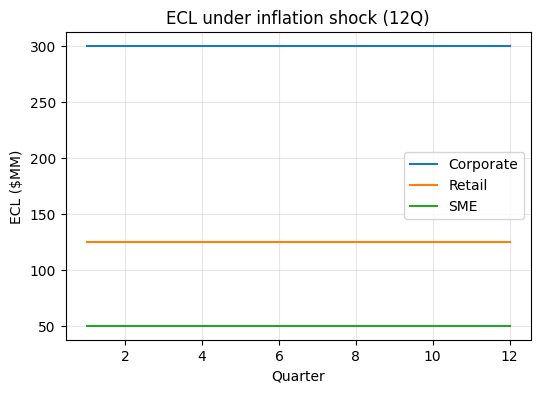

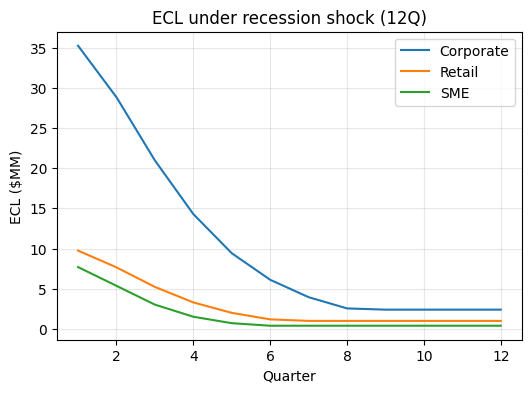

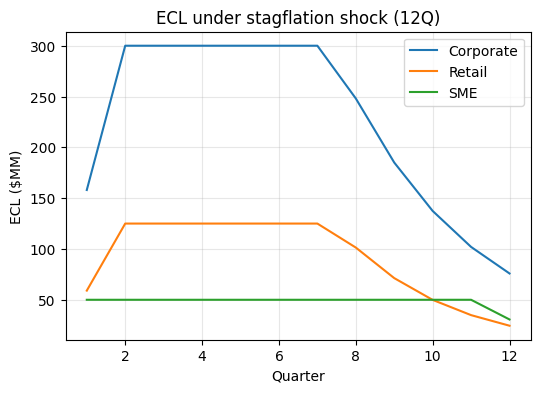

In [ ]:
# ---- Build scenario vectors from IRFs (length = 12 quarters) ----
k = 3.0  # stress scaler (same as your R `* 3`)
inflation_path  = resp_gdp_from_cpi * k     # GDP response to a CPI shock
recession_path  = resp_cpi_from_gdp * k     # CPI response to a GDP shock
stagflation_path = 0.5*(inflation_path + recession_path)

scenarios = {
    "inflation":   inflation_path,
    "recession":   recession_path,
    "stagflation": stagflation_path
}

# ---- Stylized portfolio ----
portfolio = pd.DataFrame({
    "Segment":  ["Retail", "SME", "Corporate"],
    "Exposure": [1e9, 5e8, 2e9],
    "PD_Base":  [0.02, 0.04, 0.03],
    "LGD":      [0.50, 0.40, 0.60]
})

# Elasticities: %ΔPD per 1pp Δmacro (your calibration knobs)
elasticity = {"Retail": -0.12, "SME": -0.18, "Corporate": -0.10}

def pd_multiplier(irf_val, seg):
    # IRF is in log units; multiplied by 100 to treat it like "pp".
    # Keep the same mapping for parity:
    return np.exp(elasticity[seg] * irf_val * 100)

pd_floor, pd_cap = 0.002, 0.25

# ---- Expand to quarter-by-quarter ECLs ----
rows = []
for scn, path in scenarios.items():
    for q, macro_impulse in enumerate(path, start=1):
        for _, r in portfolio.iterrows():
            mult = pd_multiplier(macro_impulse, r.Segment)
            pd_stress = np.clip(r.PD_Base * mult, pd_floor, pd_cap)
            ecl = r.Exposure * pd_stress * r.LGD / 1e6  # $MM
            rows.append((scn, q, r.Segment, pd_stress, ecl))

ecl_df = pd.DataFrame(rows, columns=["Scenario","Quarter","Segment","PD_Stress","ECL_MM"])

# ---- Visuals ----
for scn, sub in ecl_df.groupby("Scenario"):
    fig, ax = plt.subplots(figsize=(6,4))
    for seg, segdf in sub.groupby("Segment"):
        ax.plot(segdf["Quarter"], segdf["ECL_MM"], label=seg)
    ax.set_title(f"ECL under {scn} shock (12Q)")
    ax.set_xlabel("Quarter"); ax.set_ylabel("ECL ($MM)")
    ax.legend(); ax.grid(True, alpha=0.3)
    plt.show()


## IRF plots

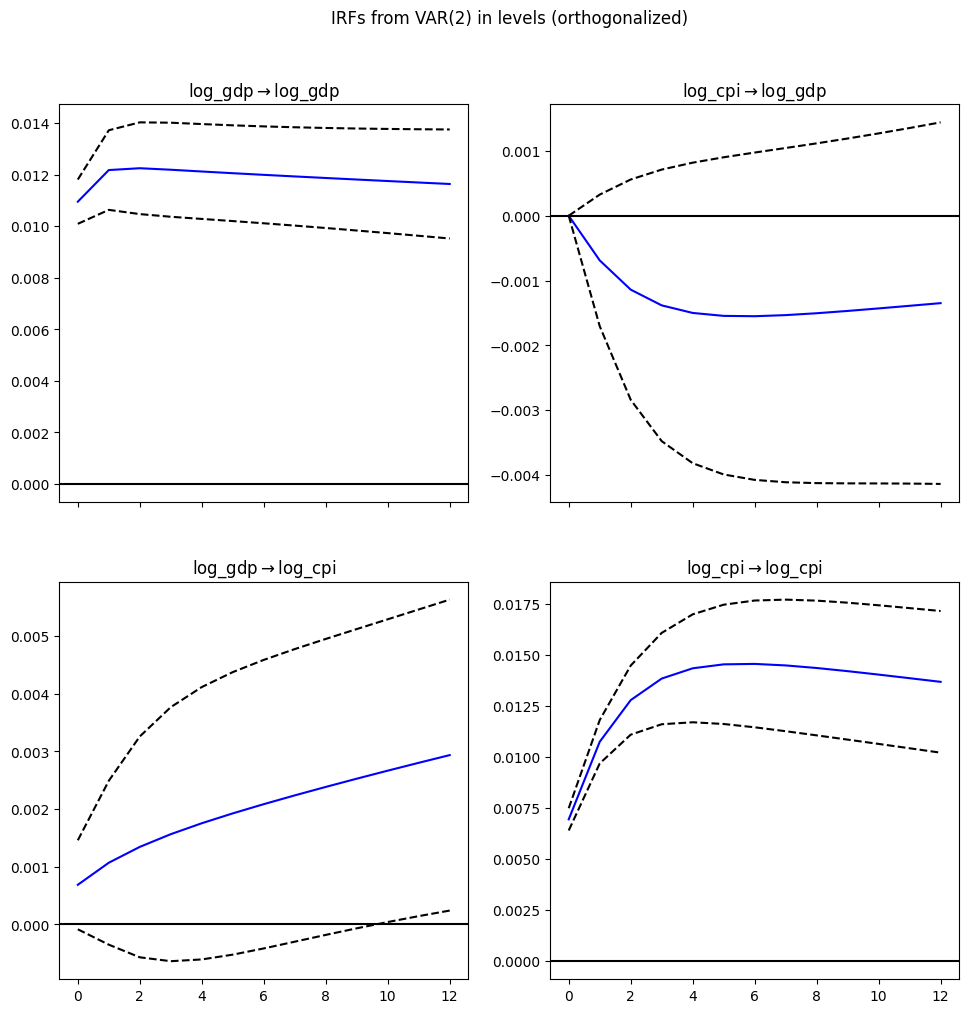

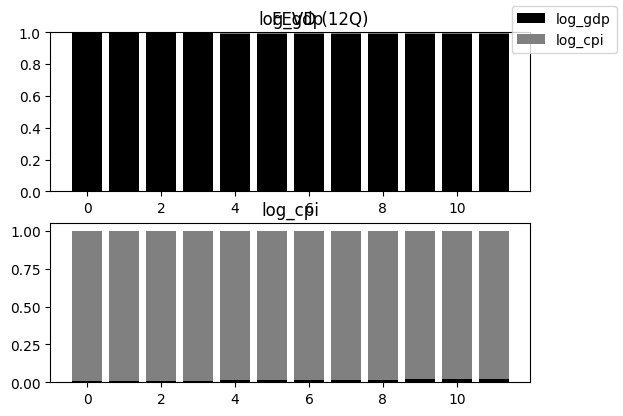

In [33]:
# IRF plots directly from statsmodels
fig = irf_cpi.plot(orth=True)   # full IRF grid
plt.suptitle("IRFs from VAR(2) in levels (orthogonalized)", y=1.02)
plt.show()

# FEVD bar/line for GDP at horizon 12
fig = fevd.plot(figsize=(6,4))
plt.suptitle("FEVD (12Q)")
plt.show()
